# League of Legends Match Predictor

### Introduction
League of Legends, a popular multiplayer online battle arena (MOBA) game, generates extensive data from matches, providing an excellent opportunity to apply machine learning techniques to real-world scenarios. Perform the following steps to build a logistic regression model aimed at predicting the outcomes of League of Legends matches. 

In [25]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset


In [26]:
data_path = Path(Path.cwd()).resolve().parents[0] / "project" / "league_of_legends_data_large.csv"


df = pd.read_csv(data_path)
X = df.drop('win', axis=1)
y = df['win']

display(X)
display(y)

,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,16,6,19,17088,231,11,7,15367
1,8,8,5,14865,259,10,2,38332
2,0,17,11,15919,169,14,5,24642
3,19,11,1,11534,264,14,3,15789
4,12,7,6,18926,124,15,7,40268
...,...,...,...,...,...,...,...,...
995,2,15,12,17170,294,8,6,33469
996,5,13,4,19524,236,14,3,8845
997,8,7,8,7961,139,11,7,49650
998,5,17,5,8226,193,9,9,28290


0      0
1      1
2      0
3      0
4      0
      ..
995    0
996    0
997    1
998    1
999    0
Name: win, Length: 1000, dtype: int64

### Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
display(f'X_train shape: {X_train.shape}')
display(f'y_train shape: {y_train.shape}')
display(f'X_test shape: {X_test.shape}')
display(f'y_test shape: {y_test.shape}')


'X_train shape: (800, 8)'

'y_train shape: (800,)'

'X_test shape: (200, 8)'

'y_test shape: (200,)'

### Standardize the feature using StandardScaler

In [28]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



### Logistic Regression Model

In [29]:
import torch.nn as nn

class LogisticRegressionNet(nn.Module):
    
    # Constructor
    def __init__(self, n_inputs):
        super(LogisticRegressionNet, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    # Prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

# Instantiate the model

input_dim = X_train.shape[1]  # Number of features

model = LogisticRegressionNet(n_inputs=input_dim)


In [30]:
print(model)

LogisticRegressionNet(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)


In [31]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [32]:
epochs = 1000
train_losses = []
test_losses = []

In [33]:


for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1).float()
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.view(-1, 1).float()
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 100 == 0:
        # Optional: calculate accuracy inline
        model.eval()
        with torch.no_grad():
            val_preds = model(X_test)
            val_binary = (val_preds > 0.5).float()
            val_acc = (val_binary == y_test).float().mean().item()
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {val_acc:.4f}')





Epoch [100/1000], Train Loss: 0.6906, Test Loss: 0.6773, Test Acc: 0.5450
Epoch [200/1000], Train Loss: 0.6907, Test Loss: 0.6775, Test Acc: 0.5350
Epoch [300/1000], Train Loss: 0.6906, Test Loss: 0.6774, Test Acc: 0.5400
Epoch [400/1000], Train Loss: 0.6907, Test Loss: 0.6775, Test Acc: 0.5350
Epoch [500/1000], Train Loss: 0.6907, Test Loss: 0.6774, Test Acc: 0.5450
Epoch [600/1000], Train Loss: 0.6906, Test Loss: 0.6774, Test Acc: 0.5400
Epoch [700/1000], Train Loss: 0.6906, Test Loss: 0.6774, Test Acc: 0.5350
Epoch [800/1000], Train Loss: 0.6906, Test Loss: 0.6775, Test Acc: 0.5400
Epoch [900/1000], Train Loss: 0.6906, Test Loss: 0.6775, Test Acc: 0.5350
Epoch [1000/1000], Train Loss: 0.6906, Test Loss: 0.6774, Test Acc: 0.5350


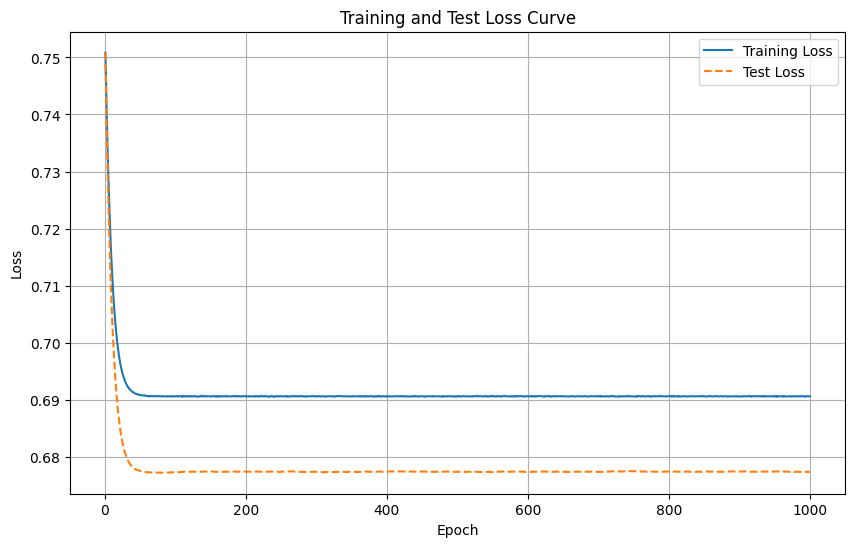

In [34]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [35]:

model.eval()
with torch.no_grad():
    # Get predictions on training set
    train_predictions = model(X_train)
    
    # Get predictions on test set  
    test_predictions = model(X_test)

# The predictions are probabilities (0 to 1) from sigmoid
print("Raw predictions (probabilities):")
print(f"Train predictions shape: {train_predictions.shape}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Sample train predictions: {train_predictions[:5].flatten()}")
print(f"Sample test predictions: {test_predictions[:5].flatten()}")

# Convert probabilities to binary predictions (0 or 1)
# Using threshold of 0.5
train_pred_binary = (train_predictions > 0.5).float()
test_pred_binary = (test_predictions > 0.5).float()

print(f"\nBinary predictions (0 or 1):")
print(f"Sample train binary predictions: {train_pred_binary[:5].flatten()}")
print(f"Sample test binary predictions: {test_pred_binary[:5].flatten()}")

# Calculate accuracy
train_accuracy = (train_pred_binary == y_train).float().mean()
test_accuracy = (test_pred_binary == y_test).float().mean()

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy.item():.4f} ({train_accuracy.item()*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy.item():.4f} ({test_accuracy.item()*100:.2f}%)")

Raw predictions (probabilities):
Train predictions shape: torch.Size([800, 1])
Test predictions shape: torch.Size([200, 1])
Sample train predictions: tensor([0.5684, 0.5011, 0.4865, 0.5669, 0.4956])
Sample test predictions: tensor([0.5175, 0.5016, 0.5204, 0.5164, 0.5478])

Binary predictions (0 or 1):
Sample train binary predictions: tensor([1., 1., 0., 1., 0.])
Sample test binary predictions: tensor([1., 1., 1., 1., 1.])

Model Performance:
Training Accuracy: 0.5238 (52.38%)
Test Accuracy: 0.5350 (53.50%)


### Model Optimization

In [36]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
epochs = 1000
train_losses = []
test_losses = []



for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1).float()
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.view(-1, 1).float()
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 100 == 0:
        # Optional: calculate accuracy inline
        model.eval()
        with torch.no_grad():
            val_preds = model(X_test)
            val_binary = (val_preds > 0.5).float()
            val_acc = (val_binary == y_test).float().mean().item()
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {val_acc:.4f}')






Epoch [100/1000], Train Loss: 0.6907, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [200/1000], Train Loss: 0.6907, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [300/1000], Train Loss: 0.6906, Test Loss: 0.6780, Test Acc: 0.5400
Epoch [400/1000], Train Loss: 0.6907, Test Loss: 0.6780, Test Acc: 0.5400
Epoch [500/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [600/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [700/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [800/1000], Train Loss: 0.6907, Test Loss: 0.6780, Test Acc: 0.5400
Epoch [900/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [1000/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400


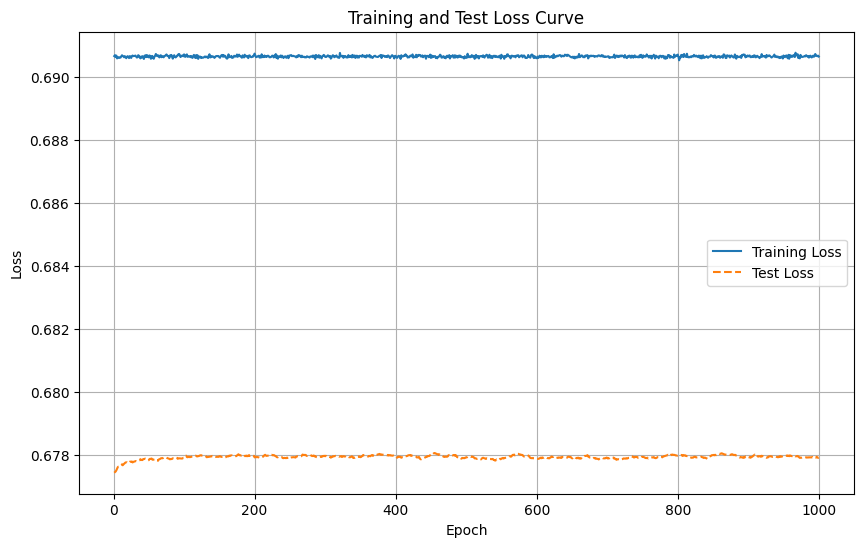

In [37]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

### Visualization and Interpretation

In [38]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

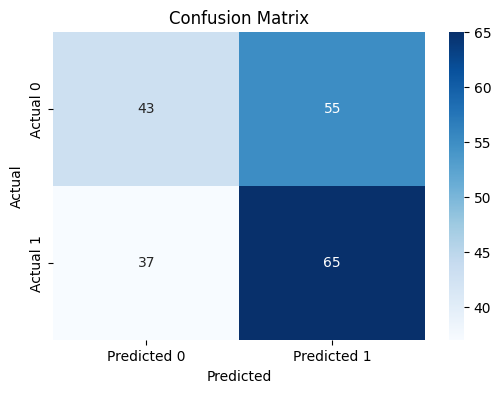

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, val_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

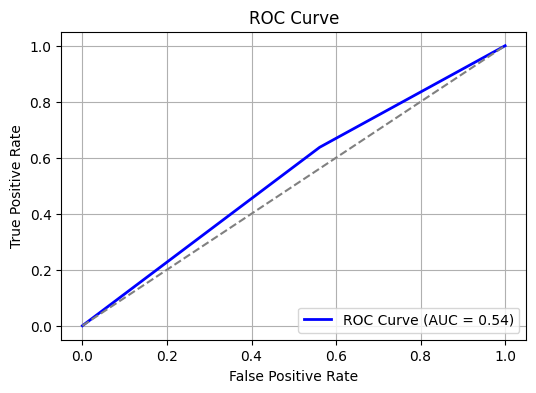

In [41]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, val_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [42]:
# Classification Report
report = classification_report(y_test, val_binary, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.54      0.44      0.48        98
     Class 1       0.54      0.64      0.59       102

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.54      0.54      0.54       200



### Save the Model

In [43]:
# Save the model's learned parameters (state_dict)
torch.save(model.state_dict(), 'logistic_model.pth')
print("Model saved successfully.")


Model saved successfully.


In [45]:
# Recreate the model structure
loaded_model = LogisticRegressionNet(n_inputs=X_train.shape[1])  # Make sure input dim is the same

# Load the saved weights into the new model instance
loaded_model.load_state_dict(torch.load('logistic_model.pth'))

# Set the model to evaluation mode
loaded_model.eval()
print("Model loaded and set to eval mode.")


Model loaded and set to eval mode.


In [46]:
# Evaluate the loaded model on test data
with torch.no_grad():
    test_preds = loaded_model(X_test)
    test_preds_label = (test_preds > 0.5).float()

# Calculate accuracy
test_acc = (test_preds_label == y_test).float().mean().item()

print(f"Loaded Model Test Accuracy: {test_acc:.4f} ({test_acc * 100:.2f}%)")


Loaded Model Test Accuracy: 0.5400 (54.00%)


### Hyperparameter tuning

In [47]:
learning_rates = [0.01, 0.05, 0.1]
num_epochs = 100
best_acc = 0
best_lr = None
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    
    model = LogisticRegressionNet(n_inputs=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

   
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.view(-1, 1).float()
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test)
        test_preds_label = (test_preds > 0.5).float()
        test_acc = (test_preds_label == y_test).float().mean().item()
        results[lr] = test_acc
        print(f"Test Accuracy for lr={lr}: {test_acc:.4f}")

        if test_acc > best_acc:
            best_acc = test_acc
            best_lr = lr


print("\nSummary of Results:")
for lr, acc in results.items():
    print(f"Learning Rate: {lr} -> Test Accuracy: {acc:.4f}")

print(f"\n Best Learning Rate: {best_lr} with Accuracy: {best_acc:.4f}")



Training with learning rate: 0.01
Test Accuracy for lr=0.01: 0.5300

Training with learning rate: 0.05
Test Accuracy for lr=0.05: 0.5300

Training with learning rate: 0.1
Test Accuracy for lr=0.1: 0.5300

Summary of Results:
Learning Rate: 0.01 -> Test Accuracy: 0.5300
Learning Rate: 0.05 -> Test Accuracy: 0.5300
Learning Rate: 0.1 -> Test Accuracy: 0.5300

 Best Learning Rate: 0.01 with Accuracy: 0.5300
